# EXPLORING THE RELATIONSHIP BETWEEN DRUG PRESCRIPTIONS AND TIME TO ICU STAY
Note: this dataset is open-source, but restricted access. You must request access via https://mimic.physionet.org/gettingstarted/access/. I downloaded the dataset onto my personal computer and ran the analyses locally. Given HIPAA and privacy considerations, I will only show summary plots from data in the database (no patient-specific information will be displayed.

This notebook utilizes previously analyzed data that looks at unique pairs of drugs that were prescribed between hospital admission and ICU stay to test whether there is information in the combinations of drugs prescribed that may predict "imminent" (e.g., <=1 day) ICU stays.<br>

Briefly, data from the PATIENTS, ADMISSIONS, ICUSTAYS, and PRESCRIPTIONS databases are merged based on subject ID, hospital admission ID, and ICU stay. Then, only drugs prescribed after hospital admission time and before ICU stay were included in the analysis. Finally, for each unique pair of drug combinations, I found all subjects where both drugs were prescribed and calculated summary statistics (mean, sem) on the time from hospital admission and ICU stay. I also, counted the number of times each pair occurred in the dataset.<br>

The code to perform these analyses is included in the Challenge Question entry, and the dataset merges follow the same logic as that in the other Jupyter Notebook linked in Asset 1 (explore_features_and_timetoicustay.ipynb). The code also includes functionality to parallel process the analysis to get through all ~400K drug combinations efficiently. This code was run on a private server with 40 processors.

In [ ]:
import pickle
import glob

In [2]:
# there are 40 pickle files that contain the data that is described above
# this cell finds the pickle files in the current directory
# drugs.pickle is a list of all unique drugs in the dataset
pckl_files = glob.glob("data/pickle/20200629/*.pickle")
drugs_pckl_file = 'drugs.pickle'
drugs = pickle.load(open(drugs_pckl_file,'rb'))

drugs_ix = pckl_files.index(drugs_pckl_file)
del pckl_files[drugs_ix]

In [3]:
# combine the data across pickle files
# combo: the counts for each drug pair in the pickle file
# mn: the mean time to ICU stay for each drug pair
# se: the SEM of time to ICU stay
# ix1: index of drugs variable for first drug in pair
# ix2: index of drugs variable for second drug in pair
all_combos = []
all_mn_days = []
all_se_days = []
all_ix1s = []
all_ix2s = []
for file in pckl_files:
    combo, mn, se, ix1, ix2 = pickle.load(open(file,'rb'))
    all_combos.extend(combo)
    all_mn_days.extend(mn)
    all_se_days.extend(se)
    all_ix1s.extend(ix1)
    all_ix2s.extend(ix2)
    

In [4]:
from matplotlib import pyplot as plt
import numpy as np

In [5]:
# sort all data by increasing time to ICU stay
sorted_mn_idx = np.argsort(all_mn_days)
all_mn_days = np.array(all_mn_days)
all_se_days = np.array(all_se_days)
all_combos = np.array(all_combos)
all_ix1s = np.array(all_ix1s)
all_ix2s = np.array(all_ix2s)

sorted_mn = np.take(all_mn_days,sorted_mn_idx)
sorted_se = np.take(all_se_days,sorted_mn_idx)
sorted_combos = np.take(all_combos,sorted_mn_idx)
sorted_ix1s = np.take(all_ix1s,sorted_mn_idx)
sorted_ix2s = np.take(all_ix2s,sorted_mn_idx)

In [43]:
# remove combos where sorted_combos ==0 (i.e., no combinations of these drugs found in dataset)
ix_keep = sorted_combos!=0
sorted_mn = sorted_mn[ix_keep]
sorted_se = sorted_se[ix_keep]
sorted_combos = sorted_combos[ix_keep]
sorted_ix1s = sorted_ix1s[ix_keep]
sorted_ix2s = sorted_ix2s[ix_keep]

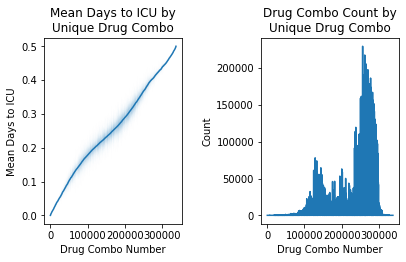

In [46]:
# plot results of mean +/- SEM of time to ICU stay and drug-pair count
figure, _ = plt.subplots(nrows=1, ncols=2)
ax = plt.subplot(1,2,1)
plt.plot(sorted_mn)
plt.fill_between(range(len(sorted_mn)),sorted_mn-1.96*sorted_se,sorted_mn+1.96*sorted_se,alpha=0.5)
xlim = ax.get_xlim()
plt.title('Mean Days to ICU by\nUnique Drug Combo')
plt.xlabel('Drug Combo Number')
plt.ylabel('Mean Days to ICU')

plt.subplot(1,2,2)
plt.plot(sorted_combos)
axes = plt.gca()
axes.set_xlim(xlim)
plt.title('Drug Combo Count by\nUnique Drug Combo')
plt.xlabel('Drug Combo Number')
plt.ylabel('Count')
figure.tight_layout(pad=2.0)

This figure plots the sorted mean time to ICU stay (left) and drug-pair count (right). We can see that, on average, all drug combinations precede an ICU stay by ~0.5 days or less. Perhaps looking at "imminent" stays <=0.25 days might be more discriminating?<br>

In any case, there is a clear relation between particular drug combinations and time to ICU stay, with certain combinations reliably preceding ICU stays by a short duration and other combinations prescribed at a more distant time relative to ICU stay.<br>

Next, I will take a look at some of the drug pairs that just precede ICU stay.

In [79]:
# let's look at the first N drugs combinations by mean ICU stay the drug IDs looks like
ix_lowest_N = 10 # this will give us 10 pairs of drugs, total of 20
drugs = np.array(drugs)
drug1_N = list(drugs[sorted_ix1s[:ix_lowest_N]])
drug2_N = list(drugs[sorted_ix2s[:ix_lowest_N]])
drug_combos_firstN = [(drug1_N[x],drug2_N[x]) for x in range(len(drug1_N))]
drug_combos_firstN

[(78035806.0, 29152725.0),
 (168016230.0, 430302015.0),
 (88222033.0, 168016230.0),
 (78035806.0, 430302015.0),
 (71015823.0, 168016230.0),
 (56017275.0, 430302015.0),
 (56017275.0, 186108839.0),
 (51079060420.0, 430302015.0),
 (56017275.0, 23317033128.0),
 (904516561.0, 430302015.0)]

# Most Frequent Drugs Combinations & Descriptions

Above I list the 10 most common drug pairs found in the dataset that preceded "imminent" ICU stays. Below, I detail the identities of each of the drugs and what they treat. Prevalent categories of drugs include those for treating skin conditions, blood clots, diabetes, and high blood pressure.

1. (78035806, 29152725): (unknown, Bactroban 2% Cream$^a$) 
2. (168016230, 430302015): (Clobetasol Propionate Top$^b$, Dovonex 0.005% cream$^c$) 
3. (88222033, 168016230): (Insulin Glargine$^d$, Clobetasol Propionate Top$^b$)
4. (78035806, 430302015): (unknown, Dovonex 0.005% cream$^c$)
5. (71015823, 168016230): (Atorvastatin$^e$, Clobetasol Propionate Top$^b$)
6. (56017275, 430302015):(Warfarin 5 MG Oral Tablet$^f$, Dovonex 0.005% cream$^c$)
7. (56017275, 186108839): (Warfarin 5 MG Oral Tablet$^f$, Metoprolol Succinate Oral$^g$)
8. (51079060420, 430302015): (Cephalexin 250 mg$^h$, Dovonex 0.005% cream$^c$)
9. (56017275, 23317033128): (Warfarin 5 MG Oral Tablet$^f$, Hydrocortisone 1 % Topical$^i$)
10. (904516561, 430302015): (Senna Lax Tab 100$^j$, Dovonex 0.005% cream$^c$)


$^a$ Bactroban is an anti-microbial cream.<br>
$^b$ Clobetasol Propionate is used to treat a variety of skin conditions (e.g., eczema, psoriasis, dermatitis, allergies, rash). Clobetasol reduces the swelling, itching, and redness that can occur in these types of conditions. This medication is a very strong (super-high-potency) corticosteroid.<br>
$^c$ Dovonex is used to treat psoriasis. Calcipotriene is a form of vitamin D. It works by slowing down the growth of skin cells.<br>
$^d$ Insulin glargine is used to treat type 1 diabetes and people with type 2 diabetes who need insulin to control their diabetes.<br>
$^e$ Atorvastatin is used along with a proper diet to help lower "bad" cholesterol and fats (such as LDL, triglycerides) and raise "good" cholesterol (HDL) in the blood.<br>
$^f$ Warfarin is used to treat and prevent blood clots that might result in heart attack, stroke, or death. It’s also used for blood clots in atrial fibrillation, heart valve replacement, venous thrombosis, and pulmonary embolism.<br>
$^g$ Metoprolol Succinate is a beta-blocker used to treat chest pain (angina), heart failure, and high blood pressure. Lowering high blood pressure helps prevent strokes, heart attacks, and kidney problems.<br>
$^h$ Cephalexin is used to treat a wide variety of bacterial infections.<br>
$^i$ Hydrocortisone is used to treat a variety of skin conditions (e.g., insect bites, poison oak/ivy, eczema, dermatitis, allergies, rash, itching of the outer female genitals, anal itching). Hydrocortisone reduces the swelling, itching, and redness that can occur in these types of conditions.<br>
$^j$ Sennosides are used to treat constipation. They may also be used to clean out the intestines before a bowel examination/surgery.<br>

<font size="1">
Descriptions of drugs were found via Google Search, WebMD (https://www.webmd.com/), and MedlinePlus (https://medlineplus.gov/) 
</font>

<br>Does this information provide any different information compared to individual drugs? To check this, I just look at the first 50K entries in the sorted mean data (corresponding to ICU times <=~0.1 days) and see which individual drugs show up most often.

Text(0.5, 0, 'NDC Code')

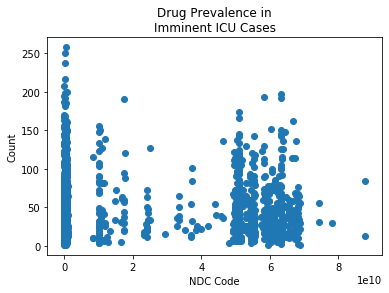

In [75]:
# let's look at the first N drugs across combinations and see what the distribution of drug IDs looks like
ix_lowest_N = 50000
drug1_N = list(drugs[sorted_ix1s[:ix_lowest_N]])
drug2_N = list(drugs[sorted_ix2s[:ix_lowest_N]])
either_drug_N = drug1_N + drug2_N

# calculate counts for each unique drug in either_drug_N
unique_drugs = sorted(list(set(either_drug_N)))
drug_counts = []
for drug in unique_drugs:
    drug_counts.append(either_drug_N.count(drug))

plt.plot(unique_drugs,drug_counts,'o')
plt.xlim([min(unique_drugs)-5000000000,max(unique_drugs)+5000000000])
plt.title('Drug Prevalence in\nImminent ICU Cases')
plt.ylabel('Count')
plt.xlabel('NDC Code')

This figure shows the counts of each unique drug in the first 50000 entries. Just for a short evaluation, I will look at the individual drugs that show up >=175 times.

In [78]:
# lets look at drugs with counts >=175
count_thresh = 175
most_frqnt_drugs = [drug for drug in unique_drugs if drug_counts[unique_drugs.index(drug)]>=count_thresh]
most_frqnt_drugs

[6353750.0,
 8084199.0,
 8092355.0,
 338001704.0,
 338001731.0,
 338004304.0,
 338004902.0,
 338004903.0,
 338004904.0,
 338004938.0,
 409665305.0,
 456066270.0,
 641040025.0,
 17314931102.0,
 58177000111.0,
 63323001302.0,
 63323018410.0]

# Most Frequent Drugs and Descriptions

Above I list some of the most individual common drugs found in the dataset that preceded "imminent" ICU stays by pairwise combination of drugs prescribed. Below, I detail the identities of each of the drugs and what they treat. Prevalent categories of drugs include those for gastrointestinal distress, antibiotics, and minerals/electrolytes.

1. 6353750: Famotidine$^a$
2. 8084199: Pantoprazole Sodium$^b$
3. 8092355.0: Pantoprazole Sodium$^b$
4. 338001704: Dextrose Monohydrate$^c$
5. 338001731: Dextrose Monohydrate$^c$
6. 338004304: Sodium Chloride$^d$
7. 338004902: Sodium Chloride$^d$
8. 338004903: Sodium Chloride$^d$
9. 338004904: Sodium Chloride$^d$
10. 338004938: Sodium Chloride$^d$
11. 409665305: Potassium Chloride$^e$
12. 456066270: Ceftaroline Fosamil$^{f*}$ 
13. 641040025: Heparin Sodium$^g$
14. 17314931102: Potassium & Sodium Phosphates Powder Pack$^h$
15. 58177000111: Potassium Chloride$^e$
16. 63323001302: Thiamine Hydrochloride$^i$
17. 63323018410: Folic Acid$^ij$

$^a$ Famotidine can treat ulcers, gastroesophageal reflux disease (GERD), and conditions that cause excess stomach acid. It can also treat heartburn caused by acid indigestion.<br>
$^b$ Pantoprazole Sodium is used to treat certain stomach and esophagus problems,such as acid reflux. It is a proton pump inhibitor.<br>
$^c$Solutions containing dextrose restore blood glucose levels, provide calories, may aid in minimizing liver glycogen depletion and exerts a protein-sparing action.<br>
$^d$Sodium Chloride is used to supply water and salt (sodium chloride) to the body. Sodium chloride solution may also be mixed with other medications given by injection into a vein.<br>
$^e$Potassium Chloride is a mineral supplement used to treat or prevent low amounts of potassium in the blood.<br>
$^f$Ceftaroline Fosamil is an antibiotic used to treat a variety of bacterial infections<br>
$^g$Heparin Sodium is used to prevent and treat blood clots.<br>
$^h$Potassium & Sodium Phosphates are used in people who cannot get enough phosphorus from their diets<br>
$^i$Thiamine is a vitamin essential for aerobic metabolism, cell growth, transmission of nerve impulses and acetylcholine synthesis<br>
$^j$Folic Acidis used to treat or prevent low folate levels. Low folate levels can lead to certain types of anemia. Conditions that can cause low folate levels include poor diet, pregnancy, alcoholism, liver disease, certain stomach/intestinal problems, kidney dialysis.<br>

<font size="1">
<br>
Descriptions of drugs were found via Google Search, WebMD (https://www.webmd.com/), and MedlinePlus (https://medlineplus.gov/)  <br>
$^*$Not sure if this is the correct drug for this code as I could not find an exact match. This was the closest match I could find.
</font>

<br>
It appears that there is, indeed, complimentary information in drug pairs rather than individual drugs themselves, suggesting that both methods my provide different information relevant for timing of ICU stay.